In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skippedcaipi.skippedcaipi import elementary_sampling, get_trajectory_indices, plot_parabola_connection, get_zblips, get_zblipcycle
import copy

In [2]:
class skippedcaipi_sampling:
    def __init__(self, matrix_size_y, matrix_size_z, Ry, Rz, CaipiShiftZ, SegmentationFactor=1):
        self.matrix_size = [matrix_size_y, matrix_size_z]
        self.R = [Ry,Rz]
        self.D = CaipiShiftZ
        self.S = SegmentationFactor
        
        self.mask = self.samplingmask()
        self.samples = np.sum(self.mask)
        
        # update actual matrix size
        self.matrix_size = self.mask.shape
        
        self.epi_factor = self.matrix_size[0]//self.R[0]
        self.sampling_repeats_z = self.matrix_size[1]//self.R[1]
        self.shots_to_measure = self.sampling_repeats_z * self.S
        
        self.indices = self.viewordering()
        
        self.zblips = get_zblips(self.R[0], self.R[1], self.D, self.S)
        self.zblip_cycle = get_zblipcycle(self.R[1],np.min(self.zblips))
        

    def has_zblips(self):
        return (self.zblip_cycle!=1)
        
    def samplingmask(self):
        Rtot = np.prod(self.R)
        sampling_cell_repeats_y = int(np.ceil(self.matrix_size[0]*1.0/Rtot))
        sampling_cell_repeats_z = int(np.ceil(self.matrix_size[1]*1.0/Rtot)) 

        # Along y, it is not necessary that the matrix size is divisable by Rtot.
        mask = elementary_sampling(self.R[0], self.R[1], self.D, sampling_cell_repeats_y-1).T
        mask = mask[:self.matrix_size[0],:]
        
        # Along z, it can make sense that the matrix size (number of "slices") are divisable by Rz.
        mask = np.tile(mask, (1,sampling_cell_repeats_z))
        mask = mask[:,:int(np.ceil(self.matrix_size[1]*1.0/Rz)*Rz)]
    
        return mask
    
    def viewordering(self):
        # First S shots ...
        sampling_indices_segmentation = [get_trajectory_indices(self.mask.T, segmentation=self.S, shot=s) for s in range(self.S)]
        sampling_indices = []
        # ... that are repeated for subsequent k-space partitions
        for instance in range(self.sampling_repeats_z):
            sampling_indices += copy.deepcopy(sampling_indices_segmentation)
            partition_offset = self.R[1] * instance
            for s in range(S):
                # Add partition offset
                sampling_indices[-S+s][:,0] += partition_offset
        return sampling_indices
    
    def plot(self, axes=None, shots=None):
        if not axes:
            axes = plt.gca()
            
        if shots==None:
            shots = range(self.shots_to_measure)

        axes.imshow(self.mask.T, cmap='gray')

        # color of trajectories encodes time:
        colors = plt.cm.hot(np.linspace(0,1,self.samples-1))
        sample = 0
        
        for s in shots:
            if s>=0 and s < self.shots_to_measure:
                actual_epi_factor = self.indices[s].shape[0]
                for echo in range(actual_epi_factor-1):
                    if not self.has_zblips():
                        plt.plot(self.indices[s][echo:echo+2,1], self.indices[s][echo:echo+2,0], color=colors[sample])
                    else:
                        #A little more realistic phase encode trajectory between echoes is plotted:
                        plot_parabola_connection(self.indices[s][echo,::-1], self.indices[s][echo+1,::-1], axis=axes, num=11, color=colors[sample], bRotate=False)
                    sample += 1

        axes.set_ylabel('Parts')
        axes.set_xlabel('Lines')

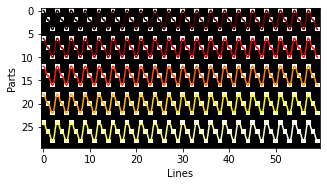

In [3]:
Ry=1 # Undersampling factor along y (primary phase encode direction, w.l.o.g.)
Rz=6 # Undersampling factor along z (slice direction, w.l.o.g.)
Dz=2 # CAIPI shift along z
S=1  # Segmentation factor (typically 1, for fMRI)

matrix_size_y = 60
matrix_size_z = 30

# Create an instance of skippedcaipi_sampling
sampling = skippedcaipi_sampling(matrix_size_y, matrix_size_z, Ry, Rz, Dz, S)

plt.figure(figsize=(5,10))
sampling.plot()
plt.show()

In [4]:
# Understand the sampling.indices list
print('The indices list has as many indices as shots to measure (per volume)')
print(sampling.shots_to_measure, len(sampling.indices))

print('The EPI factor corresponds to the number of (part/line) pairs bundled in an array per shot')
print(sampling.epi_factor, sampling.indices[0].shape)

print('The first array dimension counts the echoes')
print('The second array dimension returns the partition and the line index')
for echo in range(sampling.epi_factor//2):
    print(echo, sampling.indices[0][echo,:])



The indices list has as many indices as shots to measure (per volume)
5 5
The EPI factor corresponds to the number of (part/line) pairs bundled in an array per shot
60 (60, 2)
The first array dimension counts the echoes
The second array dimension returns the partition and the line index
0 [0 0]
1 [2 1]
2 [4 2]
3 [0 3]
4 [2 4]
5 [4 5]
6 [0 6]
7 [2 7]
8 [4 8]
9 [0 9]
10 [ 2 10]
11 [ 4 11]
12 [ 0 12]
13 [ 2 13]
14 [ 4 14]
15 [ 0 15]
16 [ 2 16]
17 [ 4 17]
18 [ 0 18]
19 [ 2 19]
20 [ 4 20]
21 [ 0 21]
22 [ 2 22]
23 [ 4 23]
24 [ 0 24]
25 [ 2 25]
26 [ 4 26]
27 [ 0 27]
28 [ 2 28]
29 [ 4 29]
